# Prétraitement des fichiers xml et application de règles de correspondance

## Importer les librairies nécessaires

In [1]:
import os
import spacy
import csv
import pandas as pd

import fonctions

from spacy.matcher import DependencyMatcher
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

nlp = spacy.load('fr_dep_news_trf')

/home/gfreijedo/miniconda3/envs/memoire/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/gfreijedo/miniconda3/envs/memoire/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Dictionnaires et patrons nécessaires à la détection des attitudes propositionnelles

In [2]:
VAPs_dict = {"croire" : 5.03, "savoir" : 8.65, "penser" : 5.46, "juger" : 7.40, "reconnaître" : 6.85, "trouver" : 5.85, "supposer" : 3.29, "apercevoir" : 'nan', "éprouver" : 8, "voir" : 5, "connaître" : 7, "concevoir" : 6, "conjecturer" : 5 , "remarquer" : 7 , 'douter' : 'nan', 'affirmer' : 'nan', 'nier':'nan'}
ADVs_negation = ['pas', 'ne', 'aucunement']

pattern_generale = [
    {
        "RIGHT_ID": "VAP",    
        "RIGHT_ATTRS": {"LEMMA": {"IN": VAPs_dict}}},
    {
        "LEFT_ID": "VAP",
        "REL_OP": ">",
        "RIGHT_ID": "sujet",
        "RIGHT_ATTRS": {"DEP": "nsubj", "ORTH": {"IN": ["J’", "Je", "je", "j’", "Nous", "nous"]}} 
        },
    {
        "LEFT_ID": "VAP",
        "REL_OP": ">",
        "RIGHT_ID": "target",
        "RIGHT_ATTRS": {"DEP": "ccomp", "OP": "{,1}"}}]

pattern_avec_adv = [
    {
        "RIGHT_ID": "VAP",    
        "RIGHT_ATTRS": {"LEMMA": {"IN": VAPs_dict}}},
    {
        "LEFT_ID": "VAP",
        "REL_OP": ">",
        "RIGHT_ID": "sujet",
        "RIGHT_ATTRS": {"DEP": "nsubj", "ORTH":{"IN": ["J’", "Je", "je", "j’", "Nous", "nous"]}}
    },
    {
        "LEFT_ID": "VAP",
        "REL_OP": ">",
        "RIGHT_ID": "adv",
        "RIGHT_ATTRS": {"POS": "ADV"} ,
    },
    {
        "LEFT_ID": "VAP",
        "REL_OP": ">",
        "RIGHT_ID": "target",
        "RIGHT_ATTRS": {"DEP": "ccomp"},}]

pattern_COND = [
    {
        "RIGHT_ID": "VAP",    
        "RIGHT_ATTRS": {"LEMMA": {"IN": VAPs_dict}}},
    {
        "LEFT_ID": "VAP",
        "REL_OP": ">",
        "RIGHT_ID": "sujet",
        "RIGHT_ATTRS": {"DEP": "nsubj", "ORTH":{"IN": ["J’", "Je", "je", "j’", "Nous", "nous"]}}
    },

    {
        "LEFT_ID": "VAP",
        "REL_OP": ">",
        "RIGHT_ID": "mark",
        "RIGHT_ATTRS": {"DEP": "mark", "ORTH" : "si"},}]

#Initialize the DependencyMatcher with the vocabulary
matcher = DependencyMatcher(nlp.vocab)
matcher.add("VAP_PATTERN", [pattern_generale])

matcher2 = DependencyMatcher(nlp.vocab)
matcher2.add("ADV_PATTERN", [pattern_avec_adv])

matcher3 = DependencyMatcher(nlp.vocab)
matcher3.add("Mark", [pattern_COND])

## Boucle sur le dossier du fichier xml pour appliquer les fonctions

In [3]:
folder_path = os.path.join(os.getcwd(), 'fichiers_XML')

for filename in os.listdir(folder_path):
    
    if filename.endswith('.xml'):
        file_path = os.path.join(folder_path, filename)
        df_generale = fonctions.parser_xml(file_path)
        path_to_csv = os.path.join(os.getcwd(), 'fichiers_CSV_complet')
        output_csv_path = os.path.join(path_to_csv, f"{os.path.splitext(filename)[0]}_complet.csv")
        df_generale.to_csv(output_csv_path, index=False)
        docs_list = fonctions.nlp_pipeline(df_generale['Phrases'], nlp)
        df_vaps = fonctions.chercher_VAPS(docs_list, df_generale, pattern_generale, matcher)
        df_avec_adv = fonctions.chercher_ADVs(df_vaps, pattern_avec_adv, matcher2)
        df_sans_cond = fonctions.chercher_COND(df_avec_adv, pattern_COND, matcher3)
        df_final = fonctions.drop_not_that_clauses(df_sans_cond)
        path_to_csv = os.path.join(os.getcwd(), 'fichiers_CSV')
        output_csv_path = os.path.join(path_to_csv, f"{os.path.splitext(filename)[0]}.csv")
        df_final.to_csv(output_csv_path, index=False)
    


## Visualizations

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Input and output folder paths
input_folder_path = 'fichiers_CSV'
output_folder_path = 'Visualizations'

### Degrees de certitude

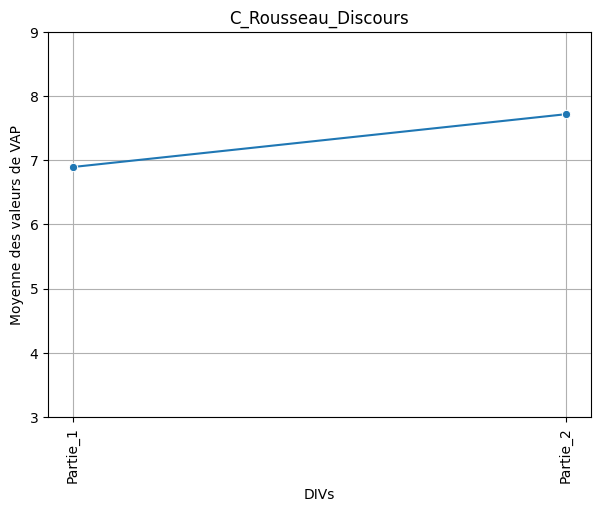

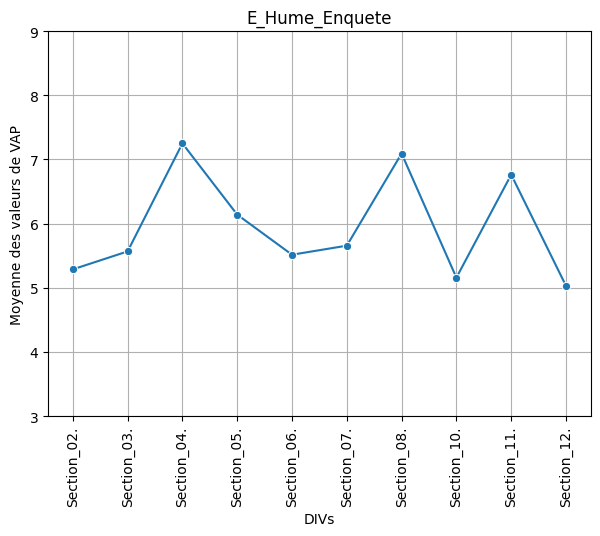

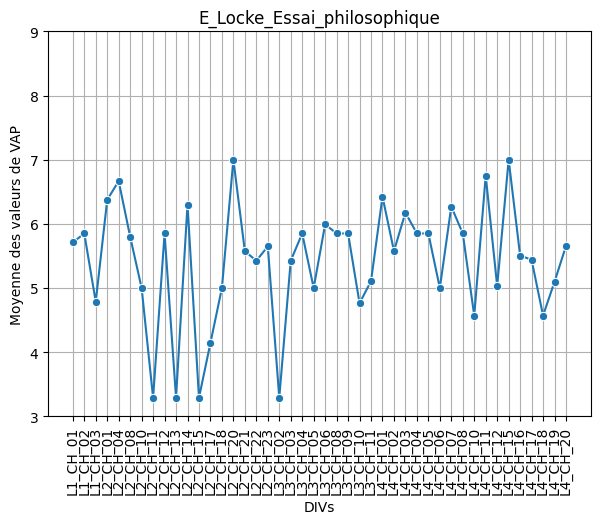

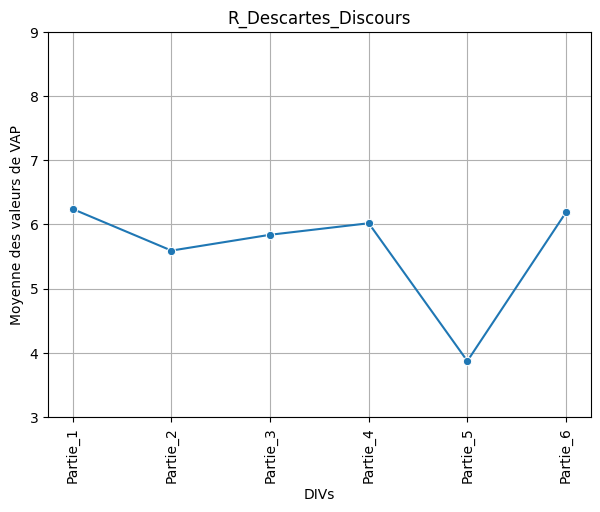

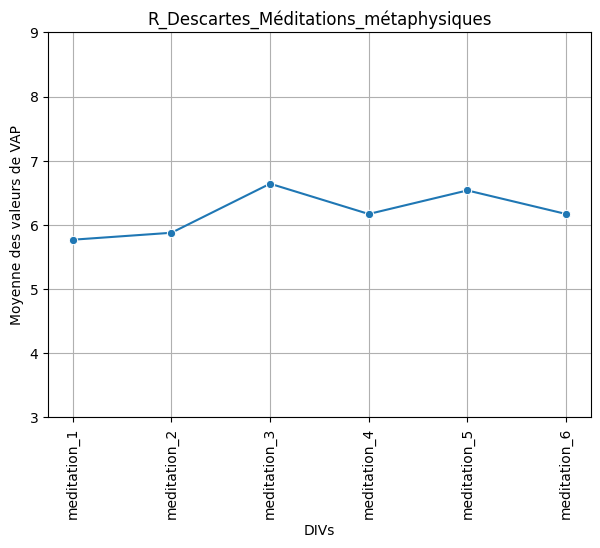

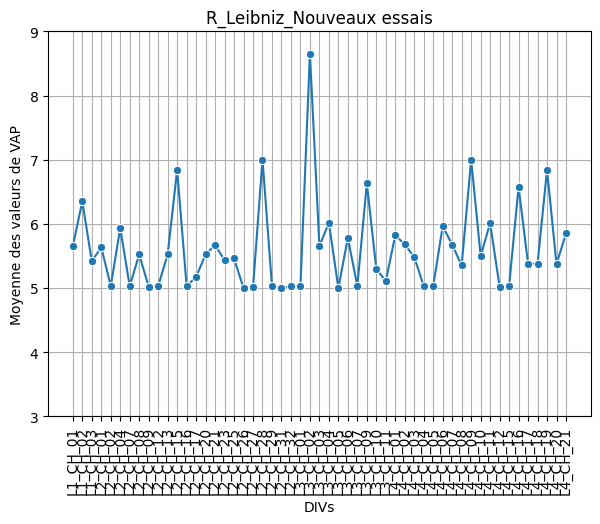

In [5]:
# Assurez-vous que le dossier de sortie existe
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Assurez-vous que le chemin du dossier d'entrée existe
if not os.path.exists(input_folder_path):
    print(f"Le chemin du dossier d'entrée {input_folder_path} n'existe pas.")
else:
    file_list = [filename for filename in os.listdir(input_folder_path) if filename.endswith(".csv")]
    
    for filename in file_list:
        file_path = os.path.join(input_folder_path, filename)
        file_title = os.path.splitext(filename)[0]

        # Lire le fichier CSV
        df = pd.read_csv(file_path)

        # Supprimer les lignes avec des valeurs manquantes dans 'VAP_values'
        df.dropna(subset=['VAP_values'], inplace=True)

        # Calculer la moyenne des VAP_values pour chaque groupe de DIVs
        avg_vap_values = df.groupby('Divs')['VAP_values'].mean().reset_index()

        # Créer une figure et un axe pour chaque graphique
        plt.figure(figsize=(7, 5))

        # Visualiser la moyenne des VAP_values pour chaque groupe de DIVs
        sns.lineplot(x='Divs', y='VAP_values', data=avg_vap_values, marker='o')
        plt.title(file_title)
        plt.xlabel('DIVs')
        plt.ylabel('Moyenne des valeurs de VAP')
        plt.ylim(3, 9)  # Définir la limite de l'axe y
        plt.xticks(rotation=90)
        plt.grid(True)

        # Sauvegarder le graphique
        output_plot_path = os.path.join(output_folder_path, f"{file_title}_average_VAP_plot.png")
        plt.savefig(output_plot_path)
        plt.show()
        plt.close()


### Répartition des verbes d'attitude par auteur.

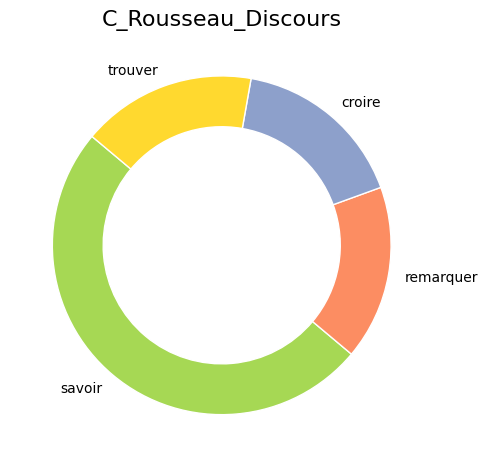

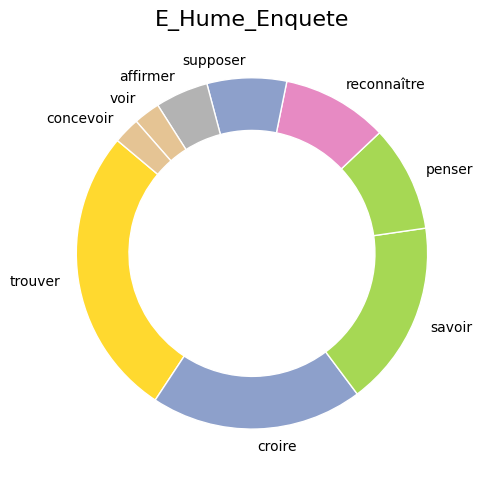

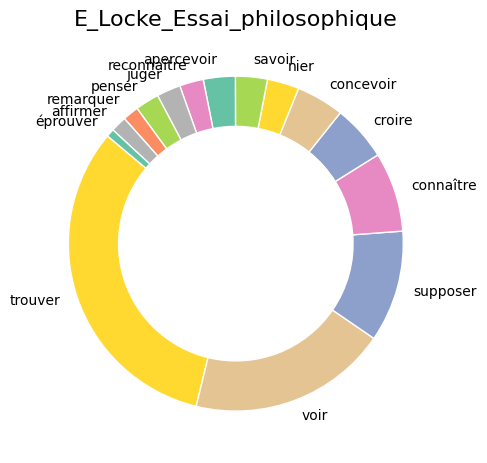

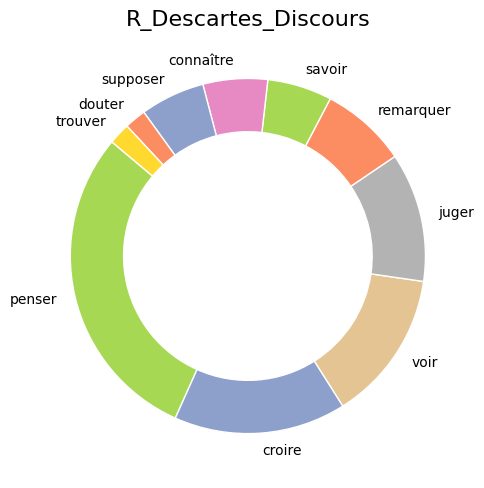

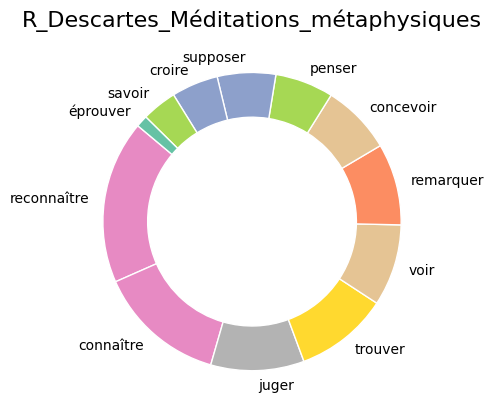

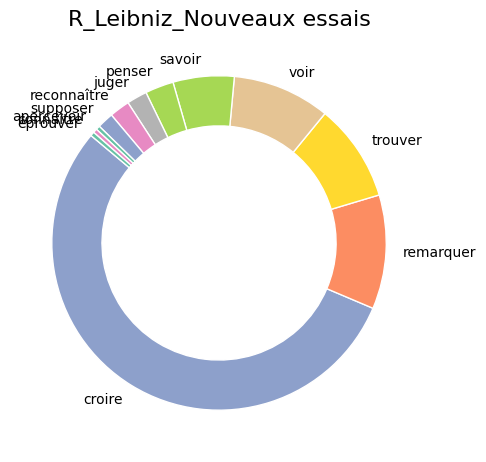

In [6]:
# Assurez-vous que le dossier de sortie existe
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Définir une palette de couleurs globale pour les valeurs de 'Lemma'
unique_lemmas = set()
for filename in os.listdir(input_folder_path):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(input_folder_path, filename))
        unique_lemmas.update(df['Lemma'].dropna().unique())

# Utiliser une palette Seaborn
color_palette = sns.color_palette("Set2", len(unique_lemmas))
lemma_colors = dict(zip(unique_lemmas, color_palette))

# Itérer sur chaque fichier CSV dans le dossier
for filename in os.listdir(input_folder_path):
    if filename.endswith('.csv'):
        # Lire le fichier CSV
        df = pd.read_csv(os.path.join(input_folder_path, filename))

        # Supprimer les lignes avec des valeurs manquantes dans 'Lemma'
        df.dropna(subset=['Lemma'], inplace=True)

        # Compter les occurrences de chaque valeur dans la colonne 'Lemma'
        lemma_counts = df['Lemma'].value_counts()

        # Obtenir les couleurs pour chaque 'Lemma'
        colors = [lemma_colors[lemma] for lemma in lemma_counts.index]

        # Tracer le graphique en secteurs
        plt.figure(figsize=(5, 5))
        plt.pie(lemma_counts, labels=lemma_counts.index, colors=colors, startangle=140, wedgeprops=dict(width=0.3, edgecolor='w'))

        # Définir le titre comme le nom du fichier sans extension
        plt.title(os.path.splitext(filename)[0], fontsize=16)

        # Sauvegarder et afficher le graphique
        plt.tight_layout()
        output_plot_path = os.path.join(output_folder_path, f"{os.path.splitext(filename)[0]}_lemma_piechart.png")
        plt.savefig(output_plot_path)
        plt.show()


## Distance semantique entre propositions

In [7]:
dataframes = {}

# Iterate over each file in the directory
for filename in os.listdir(input_folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_folder_path, filename)
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Use the filename (without extension) as the key in the dictionary
        df_name = os.path.splitext(filename)[0]
        dataframes[df_name] = df


In [8]:
# Initialize the model
model = SentenceTransformer("Lajavaness/sentence-camembert-large")

def plot_semantic_similarity(data_dict, lemma_filters, output_folder_path):
    # Convert lemma_filters to a list if it's not already one
    if not isinstance(lemma_filters, list):
        lemma_filters = [lemma_filters]
    
    # Ensure the output directory exists
    os.makedirs(output_folder_path, exist_ok=True)
    
    # Collect all embeddings and their corresponding labels
    all_embeddings = []
    all_labels = []
    all_colors = []
    
    # Define color mapping based on key prefixes
    color_mapping = {
        'E_': 'blue',
        'R_': 'green',
        'C_': 'red'
    }
    
    for file_name, df in data_dict.items():
        # Filter rows where 'Lemma' matches any value in lemma_filters
        filtered_df = df[df['Lemma'].isin(lemma_filters)]
        # Extract Target_lemma column values from the filtered dataframe
        target_lemmas = filtered_df['Target_lemma'].tolist()
        if target_lemmas:
            # Compute embeddings
            embeddings = model.encode(target_lemmas)
            # Append embeddings and corresponding labels
            all_embeddings.extend(embeddings)
            all_labels.extend([file_name] * len(embeddings))
            # Append colors based on the prefix of the file_name
            for _ in range(len(embeddings)):
                if file_name.startswith('E_'):
                    all_colors.append(color_mapping['E_'])
                elif file_name.startswith('R_'):
                    all_colors.append(color_mapping['R_'])
                elif file_name.startswith('C_'):
                    all_colors.append(color_mapping['C_'])
    
    if not all_embeddings:
        print(f"No data found for Lemma(s): {lemma_filters}")
        return
    
    # Convert to numpy array
    all_embeddings = np.array(all_embeddings)
    
    # Apply PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(all_embeddings)
    
    # Plot the results
    plt.figure(figsize=(12, 8))
    
    for color in set(all_colors):
        indices = [i for i, col in enumerate(all_colors) if col == color]
        # Modify label based on color mapping
        label = 'empiriste' if color == 'blue' else ('rationaliste' if color == 'green' else 'control')
        plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=label, color=color)
    
    plt.title(f'Semantic Similarity of Target Lemmas for VAP(s): {", ".join(lemma_filters)}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    
    # Save the plot
    output_plot_path = os.path.join(output_folder_path, f"similarite_{'_'.join(lemma_filters)}.png")
    plt.savefig(output_plot_path)
    plt.close()

VAPS = [['croire', 'penser', 'juger', 'supposer'], ["connaître", 'reconnaître','savoir','remarquer']]


for i in VAPS:
    plot_semantic_similarity(dataframes, i, output_folder_path)

/home/gfreijedo/miniconda3/envs/memoire/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
